In [19]:
import numpy as np
from glob import glob
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": "xx-large",
    "axes.labelsize": "xx-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "legend.fontsize": "large",
    "figure.titlesize": "xx-large",
    "legend.frameon": False,
    "text.usetex": True
})

In [3]:
images = []
for image in sorted(glob("csi_side/*.npy")):
    images.append(np.load(image))

images = np.vstack(images)

In [11]:
metadata = []
for meta in sorted(glob("csi_side/*.csv")):
    metadata.append(np.loadtxt(meta, delimiter=",", skiprows=1))

metadata = np.vstack(metadata)

In [12]:
charges = np.sum(images, axis=(1, 2))

In [32]:
metadata

array([[ 1.0000000e+04, -1.7736462e+01,  5.6520530e+00,  4.9350037e+01],
       [ 1.0001000e+04, -1.4481584e+01,  1.6106043e+01,  4.9373005e+01],
       [ 1.0002000e+04, -1.1492530e+01, -1.1367587e+01,  4.9314667e+01],
       ...,
       [ 9.9999700e+05, -1.5296500e+01,  1.2146146e+01,  3.3235897e+01],
       [ 9.9999800e+05,  2.7500504e-01,  1.5020062e+00,  3.1918055e+01],
       [ 9.9999900e+05, -2.3503685e+01, -2.1986947e+00,  2.1238539e+01]])

In [30]:
def get_2d_bin_contents_from_meshgrid(
    x_values,
    y_values,
    z_values,
    x_bin_edges,
    y_bin_edges,
    z_bin_edges,
    histogram_contents,
):
    # Flatten the 2D arrays to use np.digitize
    x_values_flat = x_values.ravel()
    y_values_flat = y_values.ravel()
    z_values_flat = z_values.ravel()

    # Use np.digitize to find the bin indices for each dimension
    x_bins_flat = np.digitize(x_values_flat, x_bin_edges) - 1
    y_bins_flat = np.digitize(y_values_flat, y_bin_edges) - 1
    z_bins_flat = np.digitize(z_values_flat, z_bin_edges) - 1

    # Adjust bin indices to handle values that are out of bounds
    x_bins_flat = np.clip(x_bins_flat, 0, len(x_bin_edges) - 2)
    y_bins_flat = np.clip(y_bins_flat, 0, len(y_bin_edges) - 2)
    z_bins_flat = np.clip(z_bins_flat, 0, len(z_bin_edges) - 2)

    # Access the histogram contents using the flattened bin indices
    bin_contents_flat = histogram_contents[x_bins_flat, y_bins_flat, z_bins_flat]

    # Reshape the flat bin contents back to the original meshgrid shape
    bin_contents = bin_contents_flat.reshape(x_values.shape)

    return bin_contents

xx = metadata[:, 1]
yy = metadata[:, 2]
zz = metadata[:, 3]

n, bins = np.histogramdd([xx, yy, zz], weights=charges, bins=(10,10,10))
x_edges = bins[0]
y_edges = bins[1]
z_edges = bins[2]
histogram_contents = n

# Generate a mesh grid of x and y values
x = np.linspace(min(xx), max(xx), 10)
y = np.linspace(min(yy), max(yy), 10)
z = np.linspace(min(zz), max(zz), 10)

x_values, y_values, z_values = np.meshgrid(x, y, z, indexing="ij")

# Get bin contents for the mesh grid of points
bin_contents = get_2d_bin_contents_from_meshgrid(
    x_values, y_values, z_values, x_edges, y_edges, z_edges, histogram_contents
)

# print("Bin contents for the mesh grid of points:")
interp = RegularGridInterpolator((x, y, z), bin_contents/np.max(bin_contents))

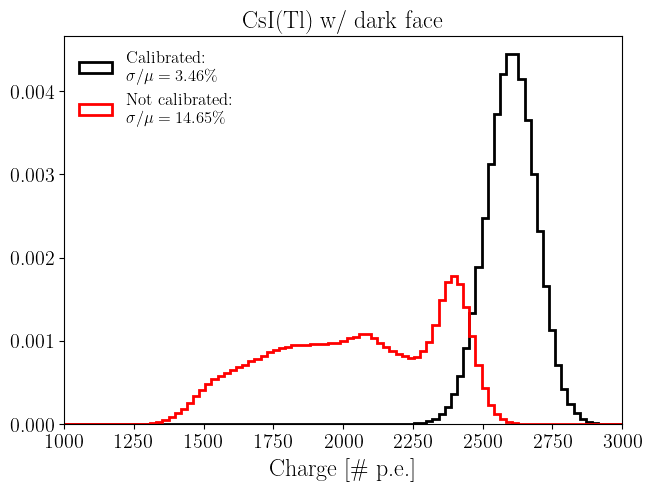

In [31]:
fig, ax = plt.subplots(constrained_layout=True)
calib_charges = charges / interp(np.vstack([xx, yy, zz]).T)
_ = ax.hist(
    calib_charges,
    bins=100,
    range=(1000, 3200),
    density=True,
    histtype="step",
    color="k",
    lw=2,
    label=f"Calibrated:\n $\sigma/\mu={np.std(calib_charges)/np.mean(calib_charges)*100:.2f}\%$",
)
_ = ax.hist(
    charges,
    density=True,
    range=(1000, 3200),
    bins=100,
    histtype="step",
    color="r",
    lw=2,
    label=f"Not calibrated:\n $\sigma/\mu={np.std(charges)/np.mean(charges)*100:.2f}\%$",
)

ax.legend()
ax.set_xlabel("Charge [\# p.e.]")
ax.set_title("CsI(Tl) w/ dark face")
ax.set_xlim(1000, 3000)
fig.savefig("csi_side_calib.pdf")